# 01 Import libraries

In [1]:
import numpy as np
import torch


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import pandas as pd

In [3]:
from scipy.optimize import minimize

# 02 Load data

In [7]:
# file path
decomp_cov_df = pd.read_csv('decomp_cov.csv')
mean_df = pd.read_csv('mean.csv')

In [8]:
decomp_cov_np = np.array(decomp_cov_df)
mean_np = np.array(mean_df).squeeze()

In [10]:
# # uncomment and run this cell to replace the covariance matrix with identity matrix

# identity_matrix = np.eye(len(decomp_cov_np))
# decomp_cov_np = identity_matrix

# 03 Compute the true solution path

We use the Naive Grid Search with $2^{10}$ grids, trained by full gradient descent with tuned learning rate = $2$ and 5000 iterations on each grid, to generate a true solution path.

In [9]:
lam_max_2d = [1, 1]
lam_min_2d = [.2, 0]
input_dim = decomp_cov_np.shape[1]

In [10]:
num_grid_2d = [100, 100]
hyper_params_2d = [[[lam_1, lam_2] for lam_2 in np.linspace(lam_max_2d[1], lam_min_2d[1], num_grid_2d[1])] for lam_1 in np.linspace(lam_max_2d[0], lam_min_2d[0], num_grid_2d[0])]
hyper_params_2d

[[[np.float64(1.0), np.float64(1.0)],
  [np.float64(1.0), np.float64(0.98989898989899)],
  [np.float64(1.0), np.float64(0.9797979797979798)],
  [np.float64(1.0), np.float64(0.9696969696969697)],
  [np.float64(1.0), np.float64(0.9595959595959596)],
  [np.float64(1.0), np.float64(0.9494949494949495)],
  [np.float64(1.0), np.float64(0.9393939393939394)],
  [np.float64(1.0), np.float64(0.9292929292929293)],
  [np.float64(1.0), np.float64(0.9191919191919192)],
  [np.float64(1.0), np.float64(0.9090909090909091)],
  [np.float64(1.0), np.float64(0.898989898989899)],
  [np.float64(1.0), np.float64(0.8888888888888888)],
  [np.float64(1.0), np.float64(0.8787878787878788)],
  [np.float64(1.0), np.float64(0.8686868686868687)],
  [np.float64(1.0), np.float64(0.8585858585858586)],
  [np.float64(1.0), np.float64(0.8484848484848485)],
  [np.float64(1.0), np.float64(0.8383838383838383)],
  [np.float64(1.0), np.float64(0.8282828282828283)],
  [np.float64(1.0), np.float64(0.8181818181818181)],
  [np.float

In [11]:
hyper_params_vector = np.array(hyper_params_2d).ravel()
hyper_params_vector

array([1.        , 1.        , 1.        , ..., 0.01010101, 0.2       ,
       0.        ])

In [12]:
n = len(hyper_params_vector) // 2  # Calculate n based on the vector size
hyper_params_matrix = hyper_params_vector.reshape(n, 2)
hyper_params_matrix

array([[1.        , 1.        ],
       [1.        , 0.98989899],
       [1.        , 0.97979798],
       ...,
       [0.2       , 0.02020202],
       [0.2       , 0.01010101],
       [0.2       , 0.        ]])

In [13]:
# Define the objective function
def objective(theta, Sigma, mu, const, hyper_params):
    # print(Sigma, mu, const, hyper_params)
    quadratic_term = hyper_params[0] * (theta.T @ Sigma @ theta)
    linear_term = -hyper_params[1] * (mu.T @ theta)
    regularizer = np.sum(np.sqrt(theta**2 + const**2) - const)
    
    return quadratic_term + linear_term + regularizer

# Define the equality constraint: sum(theta) = 1
def constraint(theta):
    return np.sum(theta) - 1

In [14]:
const = .01

# Initial guess for theta
initial_theta = np.zeros(input_dim)

cov = decomp_cov_np.T @ decomp_cov_np

# Define the constraint in a dictionary format for the 'minimize' function
# cons = {'type': 'eq', 'fun': constraint}

In [15]:
cov

array([[ 14.88694787,  17.96342851,  15.62749789,  18.15608029,
         12.8475343 ,  13.45480821,  12.39359279,  10.4856145 ,
         10.77197552,  15.05393296],
       [ 17.96342851, 114.30831417,  32.4917756 ,  36.40362025,
         40.72530978,  22.52463238,  35.4337486 ,  21.24320714,
         11.91429053,  35.77522809],
       [ 15.62749789,  32.4917756 ,  25.62290251,  28.33939666,
         21.19279383,  18.61550578,  19.31985585,  16.13689191,
         12.23087011,  24.51854274],
       [ 18.15608029,  36.40362025,  28.33939666,  77.09328733,
         19.46612271,  24.41378517,  18.68226607,  16.41267805,
         13.30689891,  31.76519195],
       [ 12.8475343 ,  40.72530978,  21.19279383,  19.46612271,
         29.886921  ,  16.34515817,  22.70028218,  16.1628709 ,
         10.16682333,  21.53193377],
       [ 13.45480821,  22.52463238,  18.61550578,  24.41378517,
         16.34515817,  23.72400703,  15.24448859,  12.99003046,
          9.9165135 ,  19.83319497],
       [ 1

In [16]:
weights = []
losses = []
for i in range(len(hyper_params_matrix)):
    hyper_params = hyper_params_matrix[i]
    # Run the optimization using 'trust-constr' method
    result = minimize(
        fun=objective,  # Objective function
        x0=initial_theta,  # Initial guess for theta
        args=(cov, mean_np, const, hyper_params),  # Arguments passed to the objective function
        method='trust-constr',  # Trust-region optimization method
        # constraints=cons  # Constraints
    )
    if i % 100 == 0:
        print(f"first {i} results found")
    weights.append(result.x)
    losses.append(result.fun)

first 0 results found
first 100 results found
first 200 results found
first 300 results found
first 400 results found
first 500 results found
first 600 results found
first 700 results found
first 800 results found
first 900 results found
first 1000 results found
first 1100 results found
first 1200 results found
first 1300 results found
first 1400 results found
first 1500 results found
first 1600 results found
first 1700 results found
first 1800 results found
first 1900 results found
first 2000 results found
first 2100 results found
first 2200 results found
first 2300 results found
first 2400 results found
first 2500 results found
first 2600 results found
first 2700 results found
first 2800 results found
first 2900 results found
first 3000 results found
first 3100 results found
first 3200 results found
first 3300 results found
first 3400 results found
first 3500 results found
first 3600 results found
first 3700 results found
first 3800 results found
first 3900 results found
first 4000 r

In [17]:
weights

[array([ 0.00142813,  0.00069995,  0.00091435, -0.00062937,  0.00872834,
        -0.00202388,  0.00423728,  0.00275385,  0.00283818,  0.00243527]),
 array([ 0.00141595,  0.00069954,  0.00090966, -0.00062229,  0.00860067,
        -0.00199942,  0.00419555,  0.00272874,  0.00280994,  0.00241377]),
 array([ 0.0014037 ,  0.00069888,  0.00090481, -0.00061524,  0.00847447,
        -0.0019751 ,  0.00415372,  0.00270352,  0.00278168,  0.00239215]),
 array([ 0.00139137,  0.000698  ,  0.00089981, -0.0006082 ,  0.0083497 ,
        -0.00195092,  0.00411179,  0.00267819,  0.00275339,  0.00237041]),
 array([ 0.00137896,  0.00069689,  0.00089466, -0.00060118,  0.00822635,
        -0.00192687,  0.00406976,  0.00265275,  0.00272508,  0.00234856]),
 array([ 0.00136648,  0.00069556,  0.00088936, -0.00059419,  0.00810439,
        -0.00190296,  0.00402764,  0.00262721,  0.00269674,  0.00232658]),
 array([ 0.00135392,  0.000694  ,  0.00088391, -0.00058721,  0.00798378,
        -0.00187918,  0.00398543,  0.00

In [18]:
losses

[np.float64(-0.013926344792950069),
 np.float64(-0.013637407201273604),
 np.float64(-0.013351800254671283),
 np.float64(-0.013069509824999328),
 np.float64(-0.012790522019745062),
 np.float64(-0.012514823180804548),
 np.float64(-0.012242399883098653),
 np.float64(-0.011973238933038631),
 np.float64(-0.01170732736686789),
 np.float64(-0.011444652448836742),
 np.float64(-0.011185201669325705),
 np.float64(-0.01092896274283347),
 np.float64(-0.010675923605848915),
 np.float64(-0.010426072414701747),
 np.float64(-0.010179397543288378),
 np.float64(-0.009935887580763619),
 np.float64(-0.009695531329175678),
 np.float64(-0.009458317801043888),
 np.float64(-0.009224236216905725),
 np.float64(-0.008993276002838885),
 np.float64(-0.00876542678794432),
 np.float64(-0.008540678401807753),
 np.float64(-0.00831902087201662),
 np.float64(-0.008100444421529546),
 np.float64(-0.007884939466182421),
 np.float64(-0.007672496612107789),
 np.float64(-0.0074631066532283505),
 np.float64(-0.0072567605686996

In [19]:
n = len(losses) // num_grid_2d[1]  # Calculate n based on the vector size
losses_2d = np.array(losses).reshape(n, num_grid_2d[1])
losses_2d

array([[-1.39263448e-02, -1.36374072e-02, -1.33518003e-02, ...,
        -5.51378253e-06, -1.37843386e-06,  0.00000000e+00],
       [-1.40016554e-02, -1.37110731e-02, -1.34238443e-02, ...,
        -5.54222011e-06, -1.38554311e-06,  0.00000000e+00],
       [-1.40779433e-02, -1.37856937e-02, -1.34968208e-02, ...,
        -5.57100756e-06, -1.39273982e-06,  0.00000000e+00],
       ...,
       [-3.60981378e-02, -3.52162862e-02, -3.43521535e-02, ...,
        -1.26670809e-05, -3.16667084e-06,  0.00000000e+00],
       [-3.69253624e-02, -3.60147320e-02, -3.51227886e-02, ...,
        -1.28710184e-05, -3.21765046e-06,  0.00000000e+00],
       [-3.78072659e-02, -3.68653132e-02, -3.59431073e-02, ...,
        -1.30827038e-05, -3.27056664e-06,  0.00000000e+00]])

In [20]:
losses_2d.shape

(100, 100)

In [21]:
thetas_list = pd.DataFrame(np.column_stack([hyper_params_matrix, np.array(weights)]))

# Save the DataFrame to a CSV file
thetas_list.to_csv('thetastar_cov_001_100_100_no_con.csv', index=False)

In [22]:
exact_soln_list = pd.DataFrame(losses_2d)

# Save the DataFrame to a CSV file
exact_soln_list.to_csv('exact_soln_list_cov_001_100_100_no_con.csv', index=False)

In [4]:
# Read the CSV file into a DataFrame
truth = pd.read_csv('exact_soln_list_cov_001_100_100.csv')

# Display the DataFrame
truth

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,11.873922,11.881742,11.889558,11.897370,11.905179,11.912983,11.920784,11.928580,11.936373,11.944162,...,12.563015,12.570518,12.578018,12.585515,12.593009,12.600500,12.607988,12.615473,12.622955,12.630434
1,11.783159,11.790981,11.798800,11.806615,11.814426,11.822233,11.830036,11.837835,11.845630,11.853421,...,12.472400,12.479904,16.487990,12.494903,12.502398,12.509890,12.517378,12.524864,12.532347,12.539827
2,11.692368,11.700194,11.708015,11.715832,11.723646,11.731455,11.739261,11.747062,11.754860,11.762654,...,12.381761,12.389266,12.396768,12.404267,12.411762,12.419255,12.426745,12.434231,12.441715,12.449196
3,11.601550,11.609378,11.617202,11.625022,11.632838,11.640650,11.648458,11.656263,11.664063,11.671859,...,12.291098,12.298603,12.306106,12.313606,12.321102,12.328596,12.336086,12.343574,12.351058,12.358540
4,11.510704,11.518534,11.526361,11.534184,11.542002,11.549817,11.557628,11.565435,11.573238,11.581036,...,12.200409,12.207915,12.215419,12.222920,12.230417,12.237912,12.245403,12.252891,12.260377,12.267859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.969864,2.978416,2.986956,2.995483,3.004000,3.012504,3.020996,3.029477,3.037946,3.046404,...,3.701677,3.709503,3.717325,3.725141,3.732953,3.740760,3.748561,3.756358,3.764149,3.771936
96,2.870990,2.879577,2.888153,2.896716,2.905267,2.913805,2.922331,2.930846,2.939348,2.947838,...,3.604494,3.612330,3.620161,3.627986,3.635807,3.643623,3.651433,3.659239,3.667039,3.674835
97,2.771868,2.780495,2.789109,2.797710,2.806299,2.814875,2.823438,2.831988,2.840526,2.849051,...,3.507194,3.515039,3.522879,3.530714,3.538544,3.546369,3.554189,3.562004,3.569813,3.577618
98,2.672482,2.681151,2.689807,2.698450,2.707080,2.715697,2.724300,2.732890,2.741467,2.750031,...,3.409775,3.417630,3.425480,3.433324,3.441164,3.448998,3.456827,3.464651,3.472470,3.480283


In [5]:
import matplotlib.pyplot as plt

In [6]:
# Read the CSV file into a DataFrame
thetastar = pd.read_csv('thetastar_cov_001_100_100_no_con.csv')

# Display the DataFrame
thetastar

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,1.000000,0.001428,0.000700,0.000914,-0.000629,0.008728,-0.002024,0.004237,0.002754,0.002838,0.002435
1,1.0,0.989899,0.001416,0.000700,0.000910,-0.000622,0.008601,-0.001999,0.004196,0.002729,0.002810,0.002414
2,1.0,0.979798,0.001404,0.000699,0.000905,-0.000615,0.008474,-0.001975,0.004154,0.002704,0.002782,0.002392
3,1.0,0.969697,0.001391,0.000698,0.000900,-0.000608,0.008350,-0.001951,0.004112,0.002678,0.002753,0.002370
4,1.0,0.959596,0.001379,0.000697,0.000895,-0.000601,0.008226,-0.001927,0.004070,0.002653,0.002725,0.002349
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.2,0.040404,0.000155,0.000275,0.000187,0.000074,0.000468,0.000023,0.000326,0.000234,0.000202,0.000243
9996,0.2,0.030303,0.000116,0.000206,0.000140,0.000055,0.000351,0.000017,0.000244,0.000176,0.000152,0.000182
9997,0.2,0.020202,0.000077,0.000138,0.000093,0.000037,0.000234,0.000011,0.000163,0.000117,0.000101,0.000121
9998,0.2,0.010101,0.000039,0.000069,0.000047,0.000018,0.000117,0.000006,0.000081,0.000059,0.000051,0.000061


In [7]:
thetastar = thetastar.to_numpy()

In [8]:
n = 100

In [9]:
import matplotlib as mpl

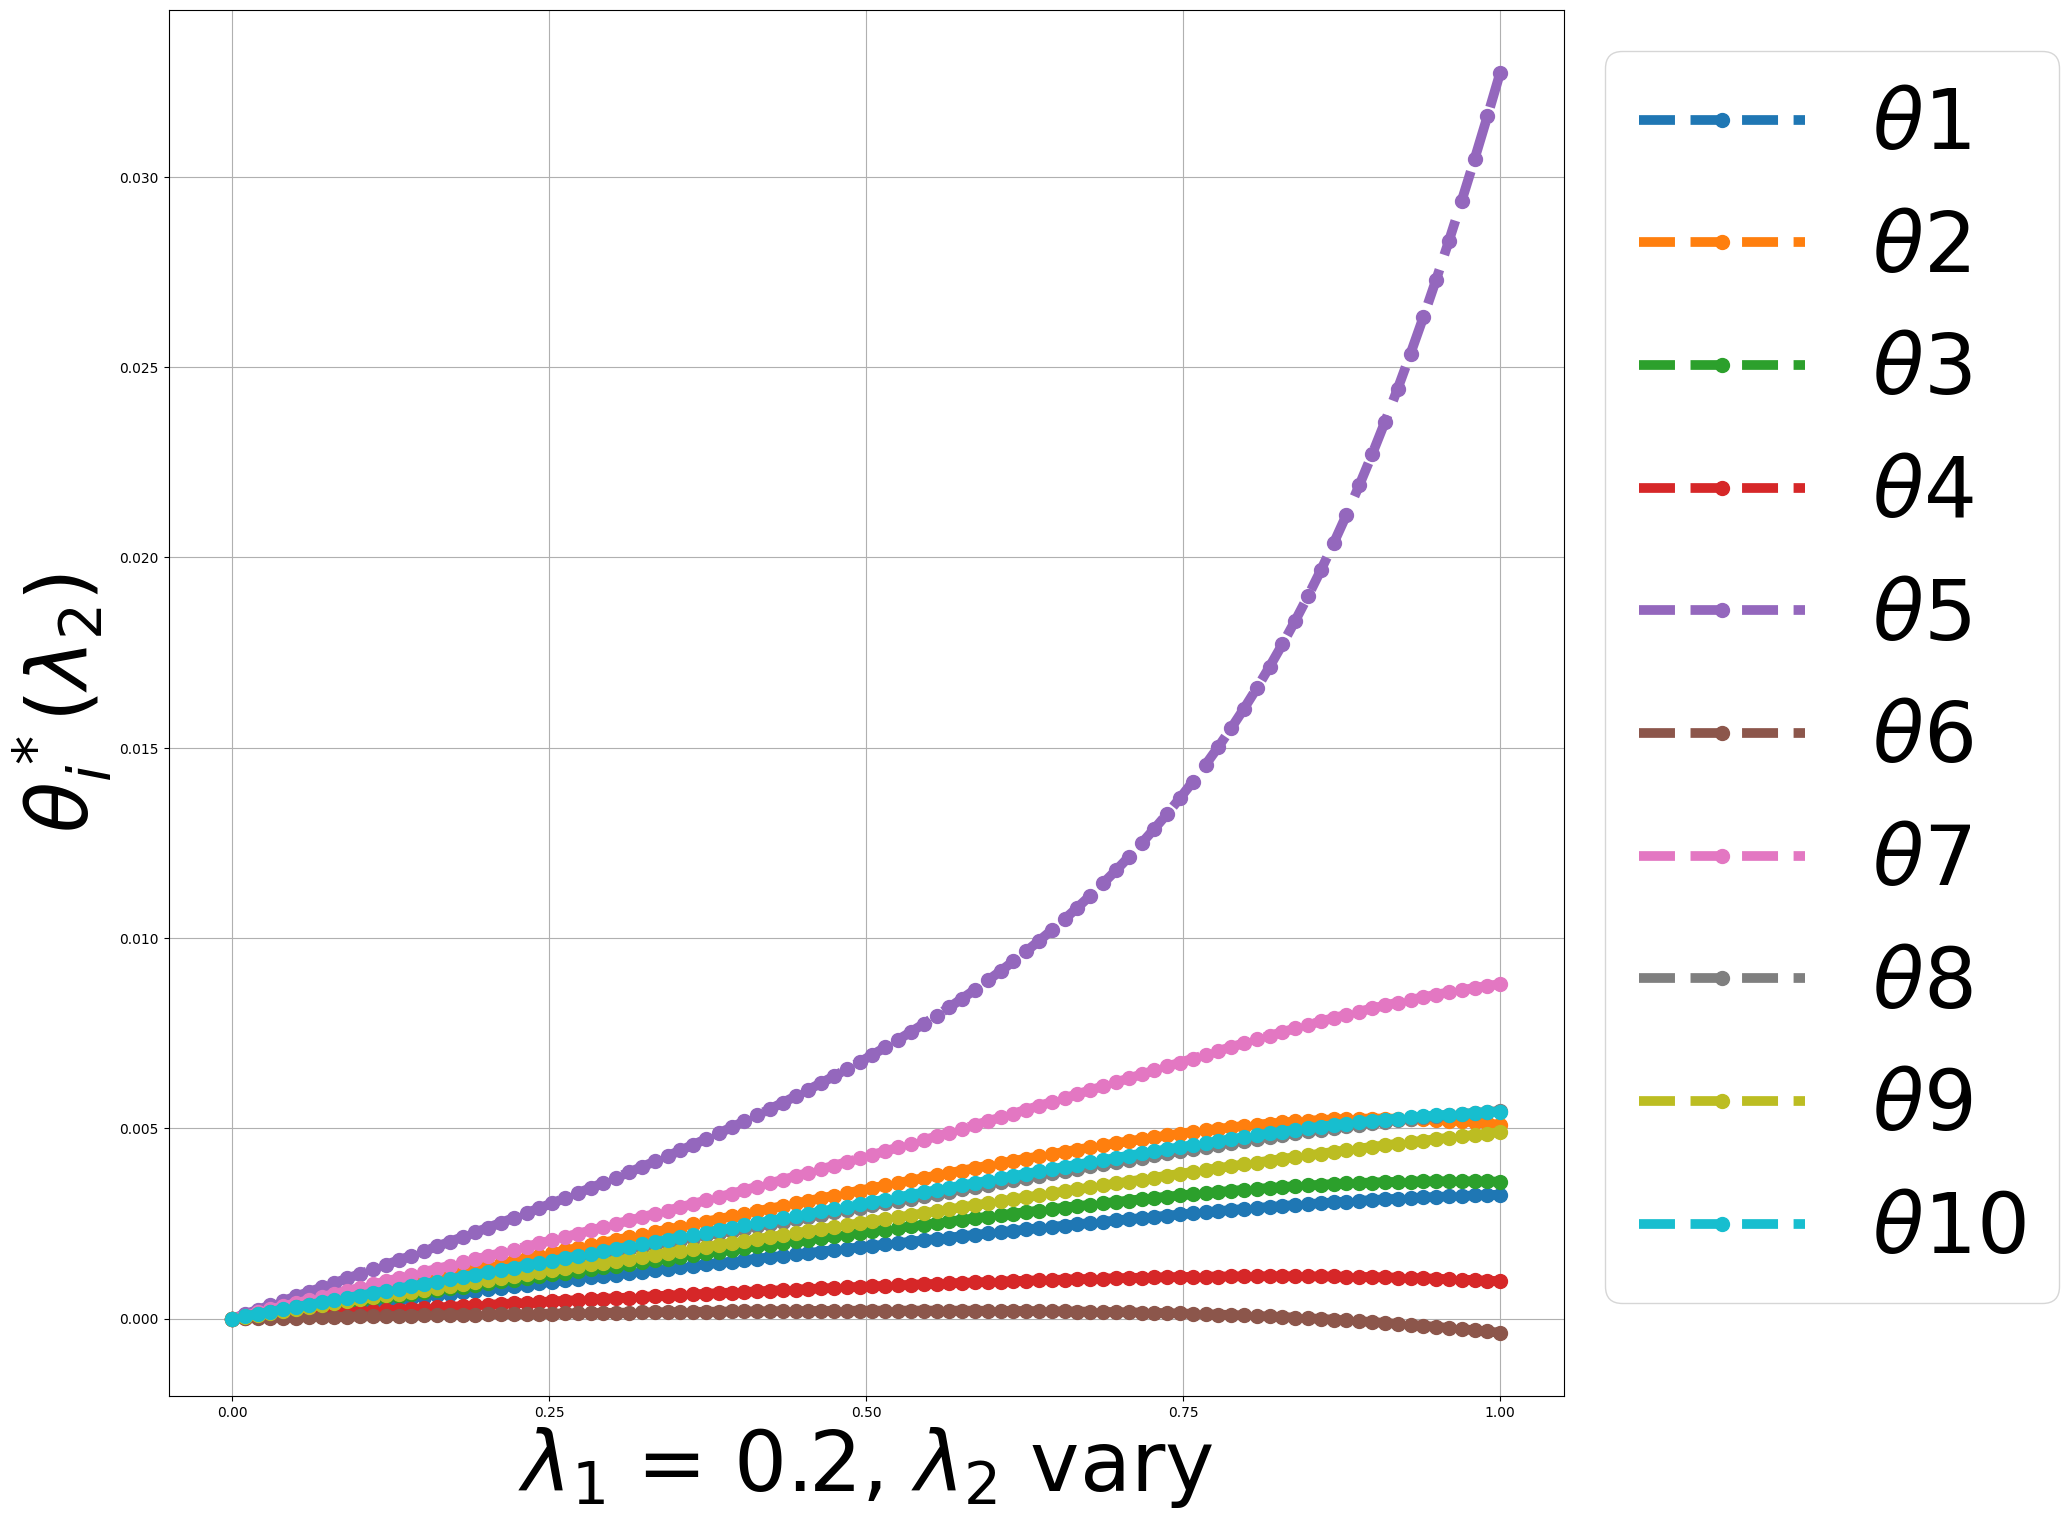

In [10]:
# plot result of our method:
plt.figure(figsize=(18,18))
start = 99 * n
for i in range(2, len(thetastar[0])):
    plt.plot(thetastar[start:start+n, 1], thetastar[start:start+n, i], '--o', linewidth=7, markersize=10, label=f'$\\theta${i-1}')
# i=5
# plt.plot(thetastar[start:start+10, 1], thetastar[start:start+10, i], '--o', label=f'lam_1 = {thetastar[start, 0]}, $\\theta${i+1}')
# Set global font size
mpl.rcParams['font.size'] = 60

font_size = 60

plt.xlabel(f'$\\lambda_1$ = {thetastar[start, 0]}, $\\lambda_2$ vary', fontsize=font_size)
plt.ylabel(f"$\\theta_i^*(\\lambda_2)$", fontsize=font_size)
plt.legend(fontsize=font_size, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

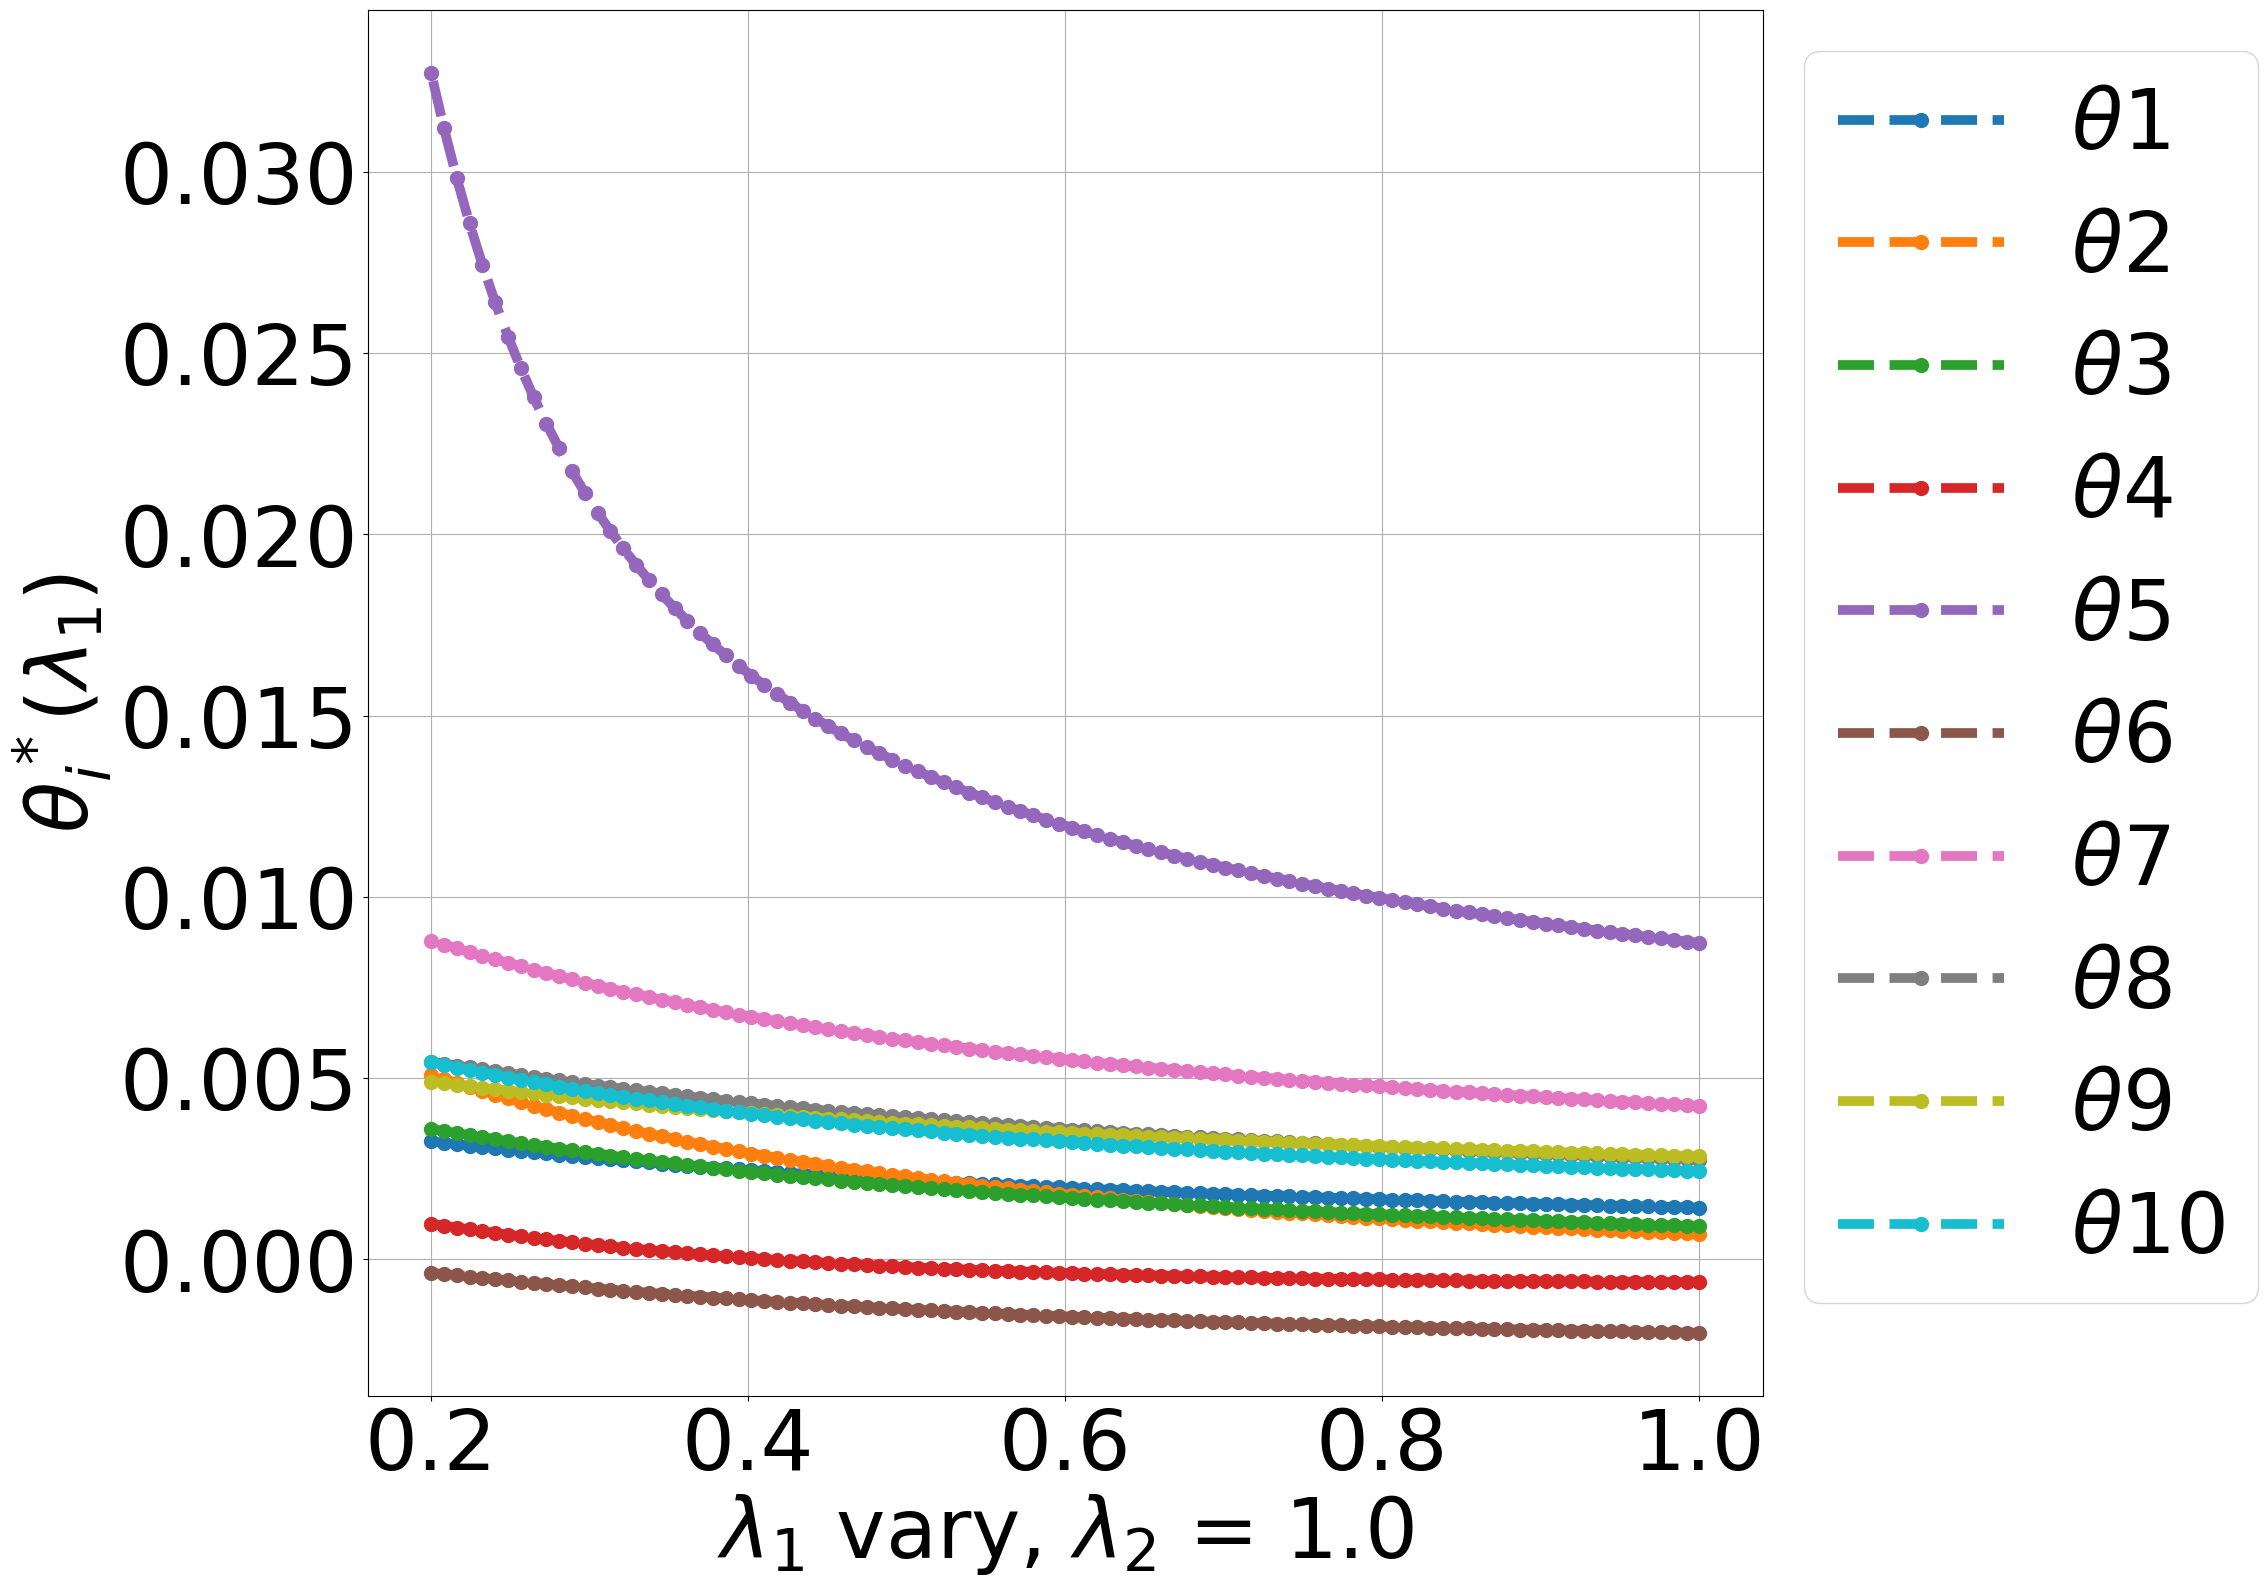

In [11]:
# plot result of our method:
plt.figure(figsize=(18,18))
start = 0
indices = np.arange(start, n**2+start, n)
for i in range(2, len(thetastar[0])):
    plt.plot(thetastar[indices, 0], thetastar[indices, i], '--o', linewidth=7, markersize=10, label=f'$\\theta${i-1}')
# i=5
# plt.plot(thetastar[start:start+10, 1], thetastar[start:start+10, i], '--o', label=f'lam_1 = {thetastar[start, 0]}, $\\theta${i+1}')
mpl.rcParams['font.size'] = 60

font_size = 60

plt.xlabel(f'$\\lambda_1$ vary, $\\lambda_2$ = {thetastar[start, 1]}', fontsize=font_size)
plt.ylabel(f"$\\theta_i^*(\\lambda_1)$", fontsize=font_size)
plt.legend(fontsize=font_size, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)